# ** Ok let's generate human 5mer mutability dictionaries** 

**note that ive changed the data from which we generate the model (hg38, no liftover complications)**
- howeevr the 5-mer model does not porduce the 3-mer model when combined.... wtf!! 

In [129]:
import pandas as pd
from Bio import AlignIO
import numpy
import matplotlib.pyplot as plt
from copy import copy 
from matplotlib.pyplot import figure

In [119]:
import json
import numpy as np

**generating the fastas dictionary** 

In [4]:
!gunzip -r data/hg38_seq/

In [5]:
list_chroms = ['chr' + str(i) for i in range(1, 23)]
fastas_dict = {}   # creating dictionary with fasta alignment, length of seq, 
for chrom in list_chroms:
    filename_tmp = "data/hg38_seq/{c}.fa".format(c=chrom)
    fastas_dict[chrom] = []
    fastas_dict[chrom].append(AlignIO.read(open(filename_tmp),"fasta"))
    alignment_tmp = fastas_dict[chrom][0]
    fastas_dict[chrom].append(len(str(alignment_tmp[0].seq)))

**reading in the 100k mutations file** 

In [6]:
mutations_lines = open('data/nature24018-s2/Aging_Oocytes_Supplementary_Table_DNMs_wrangled_unique.tsv').readlines()

In [7]:
len(mutations_lines)

100438

**making and filling the mutation dictionary**

In [85]:
#making the blank dictionary --> rememebr to always reblank if the loop ran halfway then quit, as we a rappending in the for loop below below, not resetting. 
mutations_dictionary_ref_alt = {}
nucleotides = ["A", "T", "C", "G"]

list_fuck_ups = []
indels = []

for base1 in nucleotides:
    for base2 in nucleotides:
        for base3 in nucleotides:
            for base4 in nucleotides:
                for base5 in nucleotides:
                    fivemer = base1+base2+base3+base4+base5
                    mutations_dictionary_ref_alt[fivemer] = [0,{}]
                    for base_changing in nucleotides: 
                        if base_changing != base3: 
                            mutations_dictionary_ref_alt[fivemer][1][base1+base2+base_changing+base4+base5] = 0

In [86]:
#double checks that the dictionary is of the format "XXXXX":[0,{XXXXX:0,XXXXX:0,XXXXX:0}]
assert len(mutations_dictionary_ref_alt)
for value in mutations_dictionary_ref_alt.values(): 
    assert value[0] ==0
    assert len(value[1])==3

In [87]:
               
#filling the dictionary 
#iterator = 0

for iterator,line in enumerate(mutations_lines): #chnaged to enumerate so dont need an iterator manually 
    row_split_tmp = line.split()
    if iterator >= 1: # skip the first lines 
        chrom_tmp = row_split_tmp[0]
        if chrom_tmp in list_chroms:
            site_number_tmp = int(row_split_tmp[1])-1 #need the -1 to offset properly (checked in the 0_110kmuts.... notebook)
            site = [chrom_tmp, int(site_number_tmp)]
            #print(site)

            alignment = fastas_dict[site[0]][0]

            Ref_bp = row_split_tmp[2]
            New_bp = row_split_tmp[3]
            Ref_5mer= (str(alignment[0,site[1]-2:site[1]+3].seq)).upper()#the offset is now here: site is the actual 0-based position 
            New_5mer = (str(alignment[0,site[1]-2:site[1]].seq)).upper()+str(New_bp)+(str(alignment[0,site[1]+1:site[1]+3].seq)).upper()#tested positioning
            #print(Ref_bp); print(Ref_triplet); print(New_bp); print(New_triplet)

            if Ref_5mer == New_5mer: 
                #print(Ref_triplet +" "+New_triplet+" "+str(row_split_tmp[0])+"    "++"   "+(str(alignment[0,site[1]-2])+" "+Ref_bp+"   "+str(alignment[0,site[1]])+" "+New_bp)
                list_fuck_ups.append([Ref_5mer, New_5mer, row_split_tmp])
            elif  len(Ref_5mer) == 5 and  len(New_5mer)==5 and "N" not in Ref_5mer: #s
                #ok now time to add to dictionary 
                mutations_dictionary_ref_alt[Ref_5mer][0]+=1
                mutations_dictionary_ref_alt[Ref_5mer][1][New_5mer] += 1 
            else: 
                assert len(New_bp) >= 1
                indels.append([Ref_5mer, New_5mer, row_split_tmp]) # we dont want to include indels in our model anyways 
                

        
        #break
    else: 
        print("skipped")
        #print("skipped"+line)
#     iterator += 1
    
    
 

skipped


In [11]:
with open('MutDict_5mer_2021_09_01.txt', 'w') as outfile:
    json.dump(mutations_dictionary_ref_alt, outfile)

In [13]:
iterator

100437

# **checking 5mer model against 3-mer**

In [16]:
triplet_mutCount = json.load(open("MutDict_2020_12_10.txt"))

In [25]:
for trip_key,trip_mutCount_ele in triplet_mutCount.items(): 
    cur_trip_fivemer_counts=0
    for fivemer_key,fivemer_mutCount_ele in mutations_dictionary_ref_alt.items(): 
        if fivemer_key[1:4]==trip_key: 
            cur_trip_fivemer_counts+=fivemer_mutCount_ele[0]
    print(trip_key,(trip_mutCount_ele[0]-cur_trip_fivemer_counts)/trip_mutCount_ele[0])

TCT -0.003048780487804878
GTC 0.003424657534246575
CTG -0.010416666666666666
CGT -0.0003475842891901286
GGC 0.0021382751247327157
GAT -0.007106598984771574
AGT -0.0116991643454039
TTC -0.002366863905325444
GTG -0.007268951194184839
CGC -0.005083179297597043
AAC -0.014656144306651634
ATA -0.0025188916876574307
TTA 0.0054988216810683424
TGA -0.005239030779305829
TGG -0.002728512960436562
CTA -0.013496932515337423
TCC -0.002592352559948153
AGA 0.0004975124378109452
GCA -0.004166666666666667
GAC -0.0039603960396039604
GAG -0.007905138339920948
TCG -0.011527377521613832
TGC -0.00684931506849315
ATC -0.0029239766081871343
ACC -0.0023148148148148147
ATT -0.004930524428507396
GCG -0.0004562043795620438
GCT -0.005162241887905605
CCT -0.006711409395973154
GGG -0.0044609665427509295
CCA 0.004137931034482759
CCC -0.0013458950201884253
GCC -0.009161381254404511
TAC 0.0
CGA -0.005008347245409015
TTG 0.0
TTT -0.0011409013120365088
CTT -0.001869158878504673
TAG -0.002793296089385475
CAC -0.00107758620

# **converting to 512 fivemer model (onle need half)**
- need to do half as 100kkmuts/1024 potential 5-mers = 100 range (not good enough) 

In [53]:
def reverse_complement(dna):
    """
    Str --> str 
    Note that this function will revComp everything: need appropruate if conditional to make sure you are 64-->32 not 64--> complementary 64 
    """
    rev_comped = str()
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    for base in dna:
        rev_comped=complement[base]+rev_comped
    return rev_comped

In [94]:
#making blank dict 
fivemer_globalGenomeCounts512 = {}
mutations_dictionary_ref_alt_512 = {}
for base1 in nucleotides:
    for base2 in nucleotides:
        for base3 in ["A","C"]:
            for base4 in nucleotides:
                for base5 in nucleotides:
                    fivemer = base1+base2+base3+base4+base5
                    fivemer_globalGenomeCounts512[fivemer]=0
                    mutations_dictionary_ref_alt_512[fivemer] = [0,{}]
                    for base_changing in nucleotides: 
                        if base_changing != base3: 
                            mutations_dictionary_ref_alt_512[fivemer][1][base1+base2+base_changing+base4+base5] = 0

In [96]:
#converting the triplet 
fivemer_globalGenomeCounts = json.load(open("../HumanTripletCounts/global_fivemer_counts_2021_08_31.txt"))
for fivemerKey,fivemerVal in fivemer_globalGenomeCounts.items(): 
    if fivemerKey[2] in ["T","G"]: 
        fivemer_globalGenomeCounts512[reverse_complement(fivemerKey)]+= fivemerVal
    else: 
        fivemer_globalGenomeCounts512[fivemerKey] += fivemerVal

for fivemerKey in fivemer_globalGenomeCounts512.keys(): #just double checking it worked 
    assert fivemer_globalGenomeCounts512[fivemerKey]== fivemer_globalGenomeCounts[fivemerKey]+ fivemer_globalGenomeCounts[reverse_complement(fivemerKey)]

In [99]:
for fivemerKey,fivemerVal in mutations_dictionary_ref_alt.items(): 
    if fivemerKey[2] in ["T","G"]: 
        mutations_dictionary_ref_alt_512[reverse_complement(fivemerKey)][0]+= fivemerVal[0]
        for into_fivemerKey,intofivemerVal in fivemerVal[1].items(): 
            mutations_dictionary_ref_alt_512[reverse_complement(fivemerKey)][1][reverse_complement(into_fivemerKey)]+=intofivemerVal
    else: 
        mutations_dictionary_ref_alt_512[fivemerKey][0]+= fivemerVal[0]
        for into_fivemerKey,intofivemerVal in fivemerVal[1].items(): 
            mutations_dictionary_ref_alt_512[fivemerKey][1][into_fivemerKey]+=intofivemerVal

for fivemerKey in mutations_dictionary_ref_alt_512.keys(): #just double checking it worked 
    assert mutations_dictionary_ref_alt_512[fivemerKey][0]== mutations_dictionary_ref_alt[fivemerKey][0]+ mutations_dictionary_ref_alt[reverse_complement(fivemerKey)][0]

# **making the mutability model** 

In [102]:
model = {}
for key, item in mutations_dictionary_ref_alt_512.items(): 
    n_muts = item[0]
    n_trips = fivemer_globalGenomeCounts512[key]
    mut = n_muts/n_trips
    
    into_dict = {}
    for into_trip_key,value in item[1].items(): 
        if n_muts==0: 
            assert value ==0 #iof the number of muts ttoal is 0, then all values of the sub (into) dict should be zero 
            into_dict[into_trip_key] = 0
            
        else: 
            into_dict[into_trip_key] = value/n_muts
    
    model[key] = [mut,into_dict]

** here is the model for copy/pasting purposes** 

In [104]:
with open('Model_fivemer_genomeWide-512_2021_09_02.txt', 'w') as outfile:
    json.dump(model, outfile)

## **doubling to return to size 1024**

In [113]:
model_1024 = {}
for key,value in model.items(): 
    model_1024[key]=value
    model_1024[reverse_complement(key)]=[value[0],{}]
    for into_key,into_valu in value[1].items(): 
        model_1024[reverse_complement(key)][1][reverse_complement(into_key)]=into_valu

In [114]:
model["AAAAA"], model_1024["TTTTT"]

([1.5086762938292033e-05,
  {'AATAA': 0.21895424836601307,
   'AACAA': 0.31209150326797386,
   'AAGAA': 0.46895424836601307}],
 [1.5086762938292033e-05,
  {'TTATT': 0.21895424836601307,
   'TTGTT': 0.31209150326797386,
   'TTCTT': 0.46895424836601307}])

In [115]:
with open('Model_fivemer_genomeWide_512doubled_2021_09_03.txt', 'w') as outfile:
    json.dump(model_1024, outfile)

## **calculating overall mean**

In [117]:
muts_list_1024 = []
for value in model_1024.values(): 
    muts_list_1024.append(value[0])

In [120]:
np.mean(muts_list_1024)

6.164895371853912e-05

In [124]:
muts_list_512 = []
for x in muts_list_1024: 
    if x not in muts_list_512: 
        muts_list_512.append(x)

(array([438.,  10.,   0.,   3.,  12.,  20.,  17.,   6.,   4.,   2.]),
 array([5.89098150e-06, 5.58285522e-05, 1.05766123e-04, 1.55703693e-04,
        2.05641264e-04, 2.55578835e-04, 3.05516405e-04, 3.55453976e-04,
        4.05391547e-04, 4.55329117e-04, 5.05266688e-04]),
 <BarContainer object of 10 artists>)

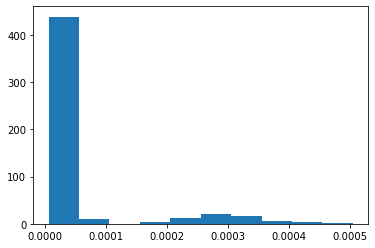

In [144]:
figure(figsize=(8, 9.5))#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
plt.hist(muts_list_512)
plt.xlabel("Relative mutability", size=17)
plt.xticks(rotation=45, size = 16)
plt.yticks(size = 16)
plt.title("Histogram of mutability in the 5-mer model", size = 18)

plt.show()
# plt.savefig("plots/mutabilityHistogram_5merModel_2021_09_14.png")

**438 5-mers in the lowest bin (which has min value of 5.89e-06)**
- 5.05266688e-04 is highest mutability 